In [1]:
!pip install mljar-supervised

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 516.2MB 24kB/s 
     |████████████████████████████████| 14.5MB 319kB/s 
     |████████████████████████████████| 10.5MB 43.3MB/s 
     |████████████████████████████████| 6.8MB 41.9MB/s 
     |████████████████████████████████| 148.9MB 100kB/s 
     |████████████████████████████████| 1.8MB 39.9MB/s 
     |████████████████████████████████| 66.1MB 87kB/s 
     |████████████████████████████████| 378kB 41.5MB/s 
     |████████████████████████████████| 296kB 41.6MB/s 
     |████████████████████████████████| 153kB 40.8MB/s 
     |████████████████████████████████| 63.8MB 63kB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 327kB 34.9MB/s 
     |████████████████████████████████| 225kB 41.7MB/s 
     |████████████████████████████████| 368kB 41.3MB/s 
     |████████████████████████████████| 460kB 37.9MB/s 
     |████████████████████████████████| 3.0MB 39.8MB

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/Anon_ML_Article/Transformed_Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Anon_ML_Article/Transformed_Test.csv')

In [7]:
train = train.set_index('ID')

In [8]:
test.head()

,ID,Manager_Num_Products_and_Applicant_Occupation_sqrt,Application_Receipt_Date_and_Manager_Num_Products,Office_PIN_and_Application_Receipt_Date_squared,Manager_Num_Products2_and_Manager_Num_Coded_sqrt,Manager_Num_Products2_and_Office_PIN_sqrt,Applicant_Occupation_and_Manager_DoB,Manager_Grade_and_Manager_Num_Products_sqrt,Manager_Num_Coded_and_Application_Receipt_Date_ln,Applicant_City_PIN_and_Manager_Num_Application_sqrt,Manager_Num_Products2_and_Applicant_Occupation_squared,Applicant_City_PIN_and_Manager_Num_Products2_sqrt,Manager_DOJ_and_Manager_Num_Products_squared,Manager_Num_Products2_and_Manager_DOJ_squared,Application_Receipt_Date_and_Manager_Num_Products_ln,Manager_Grade_and_Manager_Num_Products2_squared,Applicant_City_PIN_and_Manager_Num_Products_ln,Manager_Num_Products2_and_Applicant_BirthDate_ln,Office_PIN_and_Applicant_City_PIN,Applicant_Gender_and_Manager_Current_Designation,Manager_DOJ_and_Applicant_Marital_Status,Manager_DoB_and_Manager_Num_Products2,Manager_Num_Application_and_Manager_Num_Products2_sqrt,Manager_Num_Products2_and_Applicant_BirthDate,Manager_DoB_and_Manager_Num_Products2_squared,Applicant_Occupation_and_Manager_Num_Products2_squared,Manager_Num_Products_and_Manager_Num_Application_sqrt,Manager_Num_Application_and_Manager_Num_Products_squared,Manager_DoB_and_Manager_DOJ,Manager_Num_Products_sqrt,Applicant_Gender_and_Applicant_City_PIN,Applicant_City_PIN_and_Office_PIN_ln,Manager_Num_Products_and_Manager_DoB_squared,Manager_Num_Application_and_Application_Receipt_Date_sqrt,Manager_Num_Products2_ln,Manager_Num_Products_and_Manager_DOJ,Manager_DoB_and_Applicant_City_PIN_sqrt,Applicant_BirthDate_and_Applicant_City_PIN_ln,Manager_Num_Products2_and_Manager_Gender_sqrt,Manager_DOJ_and_Applicant_City_PIN_ln,...,Manager_Num_Products2_sqrt,Manager_Num_Application_and_Office_PIN_ln,Manager_Num_Products2_and_Application_Receipt_Date,Manager_Num_Coded_and_Applicant_Occupation_ln,Office_PIN_and_Application_Receipt_Date_sqrt,Manager_DoB_and_Manager_Num_Products,Manager_DoB_and_Manager_Joining_Designation_ln,Manager_Business2_and_Manager_Num_Products_sqrt,Manager_Business2_and_Manager_Grade_squared,Office_PIN_and_Applicant_Qualification,Applicant_City_PIN_and_Applicant_Qualification_sqrt,Manager_DOJ_and_Applicant_City_PIN_squared,Applicant_BirthDate_and_Manager_Num_Products2_ln,Manager_Num_Application_and_Manager_DOJ_ln,Manager_DoB_and_Manager_Grade_squared,Manager_Status_and_Applicant_BirthDate_squared,Manager_Business_and_Applicant_Gender_squared,Manager_Num_Coded_and_Manager_Num_Application_sqrt,Application_Receipt_Date_and_Manager_Num_Products2_squared,Manager_Status_and_Applicant_City_PIN_ln,Application_Receipt_Date_sqrt,Manager_Joining_Designation_and_Manager_Num_Application_ln,Manager_DoB_and_Office_PIN_squared,Applicant_City_PIN_and_Manager_Business2_squared,Applicant_Gender_and_Applicant_Occupation_sqrt,Applicant_BirthDate_and_Applicant_Gender,Manager_Num_Coded_and_Manager_DOJ_squared,Applicant_BirthDate_and_Manager_Num_Application,Applicant_BirthDate_and_Manager_Num_Coded,Applicant_BirthDate_and_Office_PIN_squared,Manager_Business_and_Applicant_BirthDate,Applicant_BirthDate_and_Manager_Grade,Manager_Business2_and_Manager_Num_Products2_squared,Manager_Num_Application_and_Applicant_BirthDate_squared,Applicant_Qualification_and_Manager_Joining_Designation_ln,Manager_Num_Products2_and_Applicant_City_PIN_sqrt,Applicant_City_PIN_ln,Manager_DOJ_and_Manager_DoB_squared,Manager_Num_Application_and_Manager_Num_Products_ln,Applicant_City_PIN_and_Applicant_BirthDate_ln
0,FIN1009528,1.539364,0.28125,3721.000000,1.541849,1.525092,0.335350,1.534894,1.188469,1.524557,0.136223,1.523940,0.139711,0.139711,1.188224,0.126618,1.200686,1.213515,0.306560,0.311278,0.307985,0.382121,1.529961,0.365291,0.146016,0.136223,1.529767,0.115727,0.389610,1.539294,0.310680,1.195908,0.146530,1.509231,1.214624,0.373780,1.524952,1.193922,1.557396,1.212447,...,1.539165,1.194494,0.28125,1.206027,7.937254,0.382792,1.203973,1.539477,0.101291,0.

,ID,Manager_Num_Products_and_Applicant_Occupation_sqrt,Application_Receipt_Date_and_Manager_Num_Products,Office_PIN_and_Application_Receipt_Date_squared,Manager_Num_Products2_and_Manager_Num_Coded_sqrt,Manager_Num_Products2_and_Office_PIN_sqrt,Applicant_Occupation_and_Manager_DoB,Manager_Grade_and_Manager_Num_Products_sqrt,Manager_Num_Coded_and_Application_Receipt_Date_ln,Applicant_City_PIN_and_Manager_Num_Application_sqrt,Manager_Num_Products2_and_Applicant_Occupation_squared,Applicant_City_PIN_and_Manager_Num_Products2_sqrt,Manager_DOJ_and_Manager_Num_Products_squared,Manager_Num_Products2_and_Manager_DOJ_squared,Application_Receipt_Date_and_Manager_Num_Products_ln,Manager_Grade_and_Manager_Num_Products2_squared,Applicant_City_PIN_and_Manager_Num_Products_ln,Manager_Num_Products2_and_Applicant_BirthDate_ln,Office_PIN_and_Applicant_City_PIN,Applicant_Gender_and_Manager_Current_Designation,Manager_DOJ_and_Applicant_Marital_Status,Manager_DoB_and_Manager_Num_Products2,Manager_Num_Application_and_Manager_Num_Products2_sqrt,Manager_Num_Products2_and_Applicant_BirthDate,Manager_DoB_and_Manager_Num_Products2_squared,Applicant_Occupation_and_Manager_Num_Products2_squared,Manager_Num_Products_and_Manager_Num_Application_sqrt,Manager_Num_Application_and_Manager_Num_Products_squared,Manager_DoB_and_Manager_DOJ,Manager_Num_Products_sqrt,Applicant_Gender_and_Applicant_City_PIN,Applicant_City_PIN_and_Office_PIN_ln,Manager_Num_Products_and_Manager_DoB_squared,Manager_Num_Application_and_Application_Receipt_Date_sqrt,Manager_Num_Products2_ln,Manager_Num_Products_and_Manager_DOJ,Manager_DoB_and_Applicant_City_PIN_sqrt,Applicant_BirthDate_and_Applicant_City_PIN_ln,Manager_Num_Products2_and_Manager_Gender_sqrt,Manager_DOJ_and_Applicant_City_PIN_ln,...,Manager_Num_Products2_sqrt,Manager_Num_Application_and_Office_PIN_ln,Manager_Num_Products2_and_Application_Receipt_Date,Manager_Num_Coded_and_Applicant_Occupation_ln,Office_PIN_and_Application_Receipt_Date_sqrt,Manager_DoB_and_Manager_Num_Products,Manager_DoB_and_Manager_Joining_Designation_ln,Manager_Business2_and_Manager_Num_Products_sqrt,Manager_Business2_and_Manager_Grade_squared,Office_PIN_and_Applicant_Qualification,Applicant_City_PIN_and_Applicant_Qualification_sqrt,Manager_DOJ_and_Applicant_City_PIN_squared,Applicant_BirthDate_and_Manager_Num_Products2_ln,Manager_Num_Application_and_Manager_DOJ_ln,Manager_DoB_and_Manager_Grade_squared,Manager_Status_and_Applicant_BirthDate_squared,Manager_Business_and_Applicant_Gender_squared,Manager_Num_Coded_and_Manager_Num_Application_sqrt,Application_Receipt_Date_and_Manager_Num_Products2_squared,Manager_Status_and_Applicant_City_PIN_ln,Application_Receipt_Date_sqrt,Manager_Joining_Designation_and_Manager_Num_Application_ln,Manager_DoB_and_Office_PIN_squared,Applicant_City_PIN_and_Manager_Business2_squared,Applicant_Gender_and_Applicant_Occupation_sqrt,Applicant_BirthDate_and_Applicant_Gender,Manager_Num_Coded_and_Manager_DOJ_squared,Applicant_BirthDate_and_Manager_Num_Application,Applicant_BirthDate_and_Manager_Num_Coded,Applicant_BirthDate_and_Office_PIN_squared,Manager_Business_and_Applicant_BirthDate,Applicant_BirthDate_and_Manager_Grade,Manager_Business2_and_Manager_Num_Products2_squared,Manager_Num_Application_and_Applicant_BirthDate_squared,Applicant_Qualification_and_Manager_Joining_Designation_ln,Manager_Num_Products2_and_Applicant_City_PIN_sqrt,Applicant_City_PIN_ln,Manager_DOJ_and_Manager_DoB_squared,Manager_Num_Application_and_Manager_Num_Products_ln,Applicant_City_PIN_and_Applicant_BirthDate_ln
0,FIN1009528,1.539364,0.28125,3721.000000,1.541849,1.525092,0.335350,1.534894,1.188469,1.524557,0.136223,1.523940,0.139711,0.139711,1.188224,0.126618,1.200686,1.213515,0.306560,0.311278,0.307985,0.382121,1.529961,0.365291,0.146016,0.136223,1.529767,0.115727,0.389610,1.539294,0.310680,1.195908,0.146530,1.509231,1.214624,0.373780,1.524952,1.193922,1.557396,1.212447,...,1.539165,1.194494,0.28125,1.206027,7.937254,0.382792,1.203973,1.539477,0.101291,0.

In [11]:
X_train, X_validation, y_train, y_validation = \
        train_test_split(train.drop('Business_Sourced',axis=1), train['Business_Sourced'], train_size=0.7, random_state=1234)

In [12]:
automl = AutoML(mode="Compete")
automl.fit(X_train, y_train)

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Linear', 'Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble availabe models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble', 'stack', 'ensemble_stacked']
* Step simple_algorithms will try to check up to 3 models
1_DecisionTree logloss 0.632463 trained in 4.83 seconds
2_DecisionTree logloss 0.637262 trained in 4.98 seconds
3_Linear logloss 0.531894 trained in 62.45 seconds
* Step default_algorithms will try to check up to 6 models
4_Default_RandomForest logloss 0.59473 trained in 153.68 seconds
5_Default_ExtraTrees logloss 0.5957 trained in 39.52 seconds
6_Default_Xgboost logloss 0.579577 trained in 26.63 second

AutoML(mode='Compete')

In [14]:
from sklearn import metrics

In [22]:
train_predict=pd.DataFrame(columns=['actual','prob'])
train_predict['actual']=y_train
train_predict['prob']=automl.predict_proba(X_train)
train_predict['Initial_Prediction']=automl.predict(X_train)
train_predict.head()

,actual,prob,Initial_Prediction
0,0.0,0.817559,0
1,1.0,0.549853,1
2,1.0,0.391742,1
3,0.0,0.958252,0
4,1.0,0.177838,1


In [23]:
test_predict=pd.DataFrame(columns=['actual','prob'])
test_predict['actual']=y_validation
test_predict['prob']=automl.predict_proba(X_validation)
test_predict['Initial_Prediction']=automl.predict(X_validation)
test_predict.head()

,actual,prob,Initial_Prediction
FIN1006254,1.0,0.533965,1
FIN1000397,0.0,0.971981,0
FIN1007154,1.0,0.401710,1
FIN1007200,1.0,0.437701,1
FIN1003265,0.0,0.778102,0


In [24]:
print("Training roc_auc score is :",metrics.roc_auc_score(train_predict.actual,train_predict.Initial_Prediction ))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(test_predict.actual,test_predict.Initial_Prediction))

Training roc_auc score is : 0.7280574117165034

Testing roc_auc score is : 0.6812696747114376


In [25]:
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()
i=0
for cut_off in np.linspace(0,1,100):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x > cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    print(i)
    i=i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [26]:
roc_like_df.head()

,cutoff,sensitivity,specificity
0,0.000000,0.0,1.0
0,0.010101,0.0,1.0
0,0.020202,0.0,1.0
0,0.030303,0.0,1.0
0,0.040404,0.0,1.0


In [27]:
import matplotlib.pyplot as plt

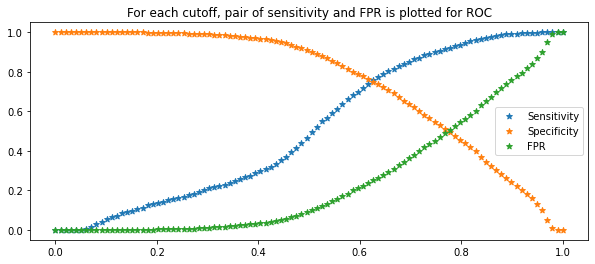

In [28]:
plt.subplots(figsize=(10,4))
plt.scatter(roc_like_df['cutoff'], roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(roc_like_df['cutoff'], roc_like_df['specificity'], marker='*', label='Specificity')
plt.scatter(roc_like_df['cutoff'], 1-roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [29]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.656566,0.802074,0.708085,1.510159


In [30]:
cut=round(roc_like_df[roc_like_df['total']==roc_like_df['total'].max()].cutoff[0],5)

In [31]:
cut

0.65657

In [32]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x < cut else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x < cut else 0)

In [33]:
import seaborn as sns

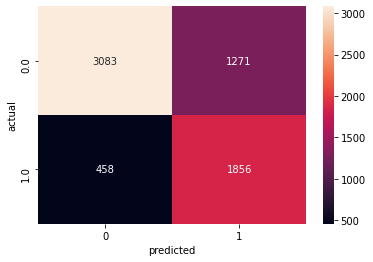

In [34]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')

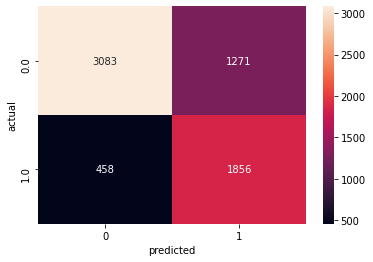

In [35]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')

In [36]:
from sklearn import metrics

In [37]:
print("Training roc_auc score is :",metrics.roc_auc_score(train_predict.actual,train_predict.predicted ))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(test_predict.actual,test_predict.predicted))
print()
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual,train_predict.predicted ))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual,test_predict.predicted))

Training roc_auc score is : 0.755079425072922

Testing roc_auc score is : 0.6901888772298006

The overall accuracy score for the Train Data is :  0.7407018596280743
The overall accuracy score for the Test Data  is :  0.6789087093389297


In [38]:
roc_auc_dict = {}
for roc_cutoff in np.linspace(0,1,100):
#     print(roc_cutoff)
    roc_auc_dict[roc_cutoff] = {}
    train_metric = train_predict['prob'].apply(lambda x: 1 if x < roc_cutoff else 0)
    roc_auc_dict[roc_cutoff]['train'] = metrics.roc_auc_score(train_predict.actual,train_metric )
    test_metric = test_predict['prob'].apply(lambda x: 1 if x < roc_cutoff else 0)
    roc_auc_dict[roc_cutoff]['test'] = metrics.roc_auc_score(test_predict.actual,test_metric )

In [39]:
roc_df = pd.DataFrame.from_dict(roc_auc_dict,orient='index').reset_index()

In [40]:
roc_df.loc[roc_df['train'].argmax(),:]

index    0.656566
train    0.755079
test     0.690189
Name: 65, dtype: float64

In [41]:
roc_df.loc[roc_df['test'].argmax(),:]

index    0.606061
train    0.748807
test     0.693075
Name: 60, dtype: float64

In [42]:
test_predict['predicted_roc'] = test_predict['prob'].apply(lambda x: 1 if x < 0.606 else 0)
train_predict['predicted_roc'] = train_predict['prob'].apply(lambda x: 1 if x < 0.606 else 0)

In [43]:
print("Training roc_auc score is :",metrics.roc_auc_score(train_predict.actual,train_predict.predicted_roc ))
print()
print("Testing roc_auc score is :",metrics.roc_auc_score(test_predict.actual,test_predict.predicted_roc))
print()
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual,train_predict.predicted_roc ))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual,test_predict.predicted_roc))

Training roc_auc score is : 0.7489218032951549

Testing roc_auc score is : 0.6930745015739769

The overall accuracy score for the Train Data is :  0.7576484703059388
The overall accuracy score for the Test Data  is :  0.7065407485134663
